In [10]:
import os
import datetime
from IPython.display import clear_output

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.loader.dataloader import DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from ClusterDataset import ClusterDataset
from training import *
from GNN_TrackLinkingNet import GNN_TrackLinkingNet, FocalLoss, weight_init

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the dataset
hist_folder = "/eos/user/c/czeh/histo_new/"
data_folder_training = "/eos/user/c/czeh/graph_data"
data_folder_test = "/eos/user/c/czeh/graph_data_test"

model_folder = "/eos/user/c/czeh/model"
dataset_training = ClusterDataset(data_folder_training, hist_folder)
dataset_test = ClusterDataset(data_folder_test, hist_folder, test=True)

In [4]:
dataset_training.get(0)

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

Data(x=[20, 29], edge_index=[2, 74], y=[74], num_nodes=20, edges_features=[74, 7])

In [5]:
train_dl = DataLoader(dataset_training, shuffle=True)
test_dl = DataLoader(dataset_test, shuffle=True)

In [13]:
epochs = 500
start_epoch = 0

model = GNN_TrackLinkingNet(input_dim = dataset_training.get(0).x.shape[1], 
                                edge_feature_dim=dataset_training.get(0).edges_features.shape[1],
                                edge_hidden_dim=16, hidden_dim=16, weighted_aggr=True)
                               #dropout=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=20, gamma=0.5)

scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-6)
loss_obj = FocalLoss(alpha=0.45, gamma=2)

model.apply(weight_init)

weights = torch.load(model_folder + "/model_epoch_100_loss_26.8352_2025-05-13.pt", weights_only=True)
model.load_state_dict(weights["model_state_dict"])
optimizer.load_state_dict(weights["optimizer_state_dict"])
start_epoch = weights["epoch"]

/eos/home-i04/c/czeh/SWAN_projects/Graph_Linking/ClusterDataset.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(osp.join(self.processed_dir, f'data_{

>>> Saving model to /eos/user/c/czeh/model/model_epoch_500_loss_23.4521.pt


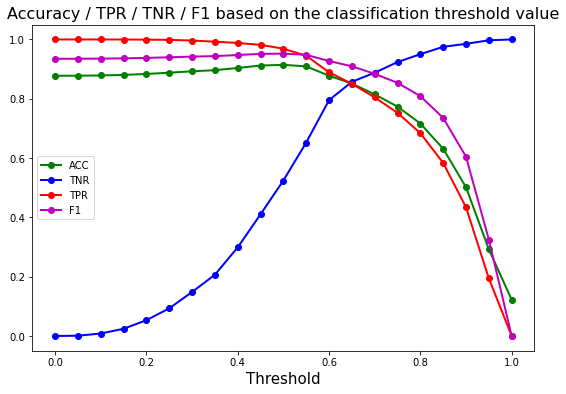

Chosen classification threshold is: 0.65
Edge labels: number of positive: 15286.914499999999
Predictions: number of positive: 13602


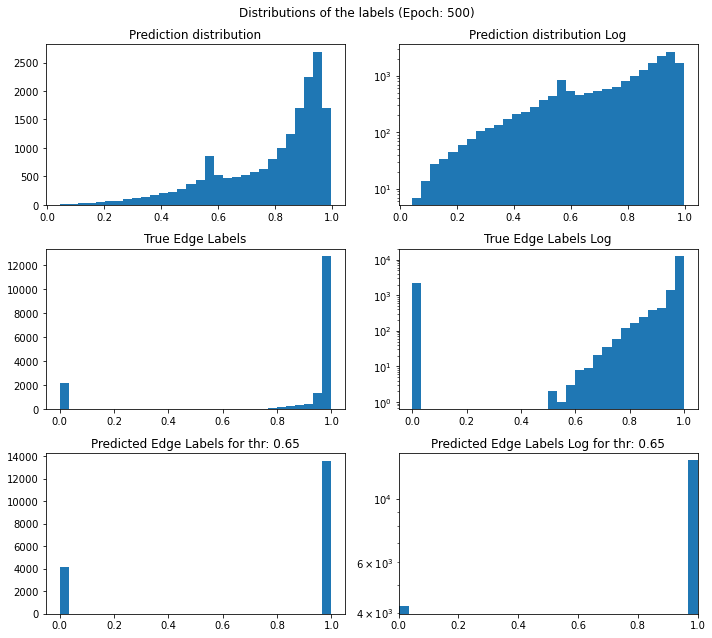

[0.87788022 0.83495557 0.89906895 ... 0.85409075 0.76291823 0.72946042]
Confusion matrix:
[[ 1867   311]
 [ 2336 13291]]

Confusion matrix weighted:
[[0.42860422 0.07139578]
 [0.07474243 0.42525757]]

TN: 1867 	 FN: 2336 	 TP: 13291 	 FP: 311
Confusion matrix scaled:
[[0.10485819 0.017467  ]
 [0.1311991  0.74647571]]

Accuracy: 0.8513
Precision: 0.9771
Negative predictive value: 0.4442
Recall: Correctly classifying 85.0515 % of positive edges
True negative rate: Correctly classifying 85.7208 % of all negative edges
F1 score: 0.9094
[0.85150903 0.85624626] [0.85720845 0.85051513] [0.85434923 0.85337107]
Balanced accuracy: 0.8539
Precision weighted: [0.85150903 0.85624626]
Recall weighted: [0.85720845 0.85051513]
F1 score weighted: [0.85434923 0.85337107]
positive_likelihood_ratio: 5.956340713790564, negative_likelihood_ratio: 0.1743856657799328


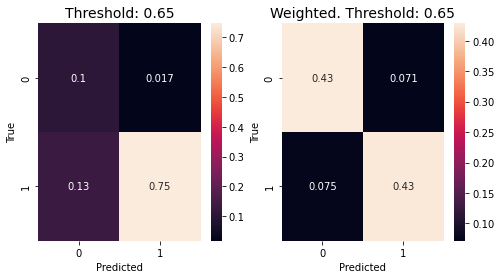

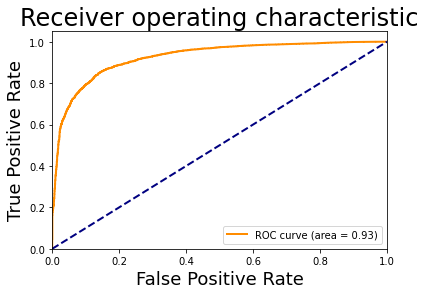

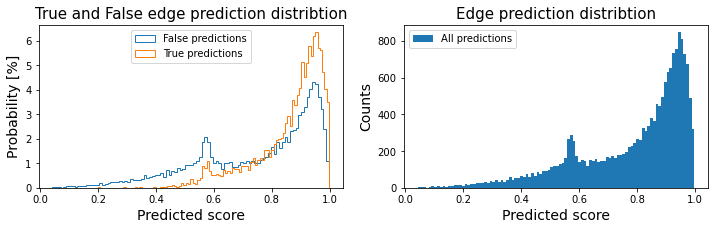

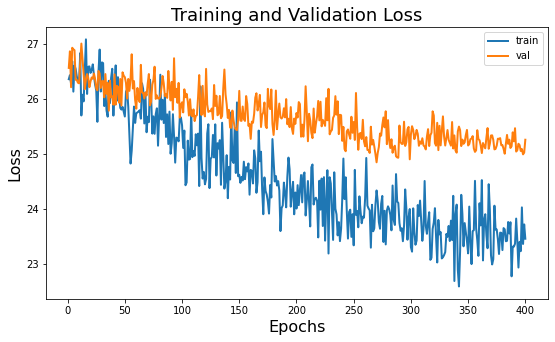

In [14]:
decision_th = 0.5
os.makedirs(model_folder, exist_ok=True)

train_loss_hist = []
val_loss_hist = []
edge_features = True

for epoch in range(start_epoch, epochs):
    loss = train(model, optimizer, train_dl, epoch+1, device=device, edge_features=edge_features, loss_obj=loss_obj)
    train_loss_hist.append(loss)
    print(f'Epoch: {epoch+1}, train loss: {loss:.4f}')
    
    # Validation
    model.eval()
    pred, lab, y = [], [], []
    val_loss, j = 0, 0
    print("Validation step")
    for sample in tqdm(test_dl, desc="Validation"):
        sample = sample.to(device)
        
        if edge_features:
            if sample.edge_index.shape[1] != sample.edges_features.shape[0]:
                continue
            data = prepare_network_input_data(sample.x, sample.edge_index, edge_features=sample.edges_features)
        else: 
            data = prepare_network_input_data(sample.x, sample.edge_index)
        #nn_pred, edge_emb = model(*data, device=device)
        nn_pred = model(*data, device=device)
        pred += nn_pred.tolist()
        y += (sample.y>0).int().tolist()
        lab += sample.y.tolist()
        val_loss += loss_obj(nn_pred, sample.y.float()).item()
        j += 1
        
    val_loss = float(val_loss)/j
    print(f'Epoch: {epoch+1}, val loss: {val_loss:.4f}')
    val_loss_hist.append(val_loss)
    
#     if (True):
    if ((epoch+1) % 20 == 0):
        clear_output(wait=True)
        
        print(f">>> Saving model to {model_folder + f'/model_epoch_{epoch+1}_loss_{loss:.4f}.pt'}")
        torch.save({'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, model_folder + f'/model_epoch_{epoch+1}_loss_{loss:.4f}_{datetime.datetime.now():%Y-%m-%d}.pt')
        
        TNR, TPR, thresholds = classification_thresholds_plot(np.array(pred), np.array(y),
                                                              threshold_step=0.05, output_folder=model_folder,
                                                              epoch=epoch+1)
        classification_threshold = get_best_threshold(TNR, TPR, thresholds)
        print(f"Chosen classification threshold is: {classification_threshold}")

        plot_prediction_distribution_standard_and_log(np.array(pred), np.array(lab),
                                                      epoch=epoch+1, thr = classification_threshold,
                                                     folder=model_folder, val=True)

        test(np.array(y), np.array(pred), classification_threshold=classification_threshold,
                            output_folder=model_folder, epoch=epoch+1)
        save_pred(np.array(pred), np.array(lab), epoch=epoch, out_folder=model_folder)
        save_loss(train_loss_hist, val_loss_hist, outputLossFunctionPath=model_folder)

    scheduler.step() 